In [14]:
!pip install dice-ml --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 83.1 MB/s eta 0:00:00


In [15]:
#load dataset
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [16]:
#train xgboost model
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2 Score:", r2)


RMSE: 0.44292272783869774
R2 Score: 0.8502905992757872


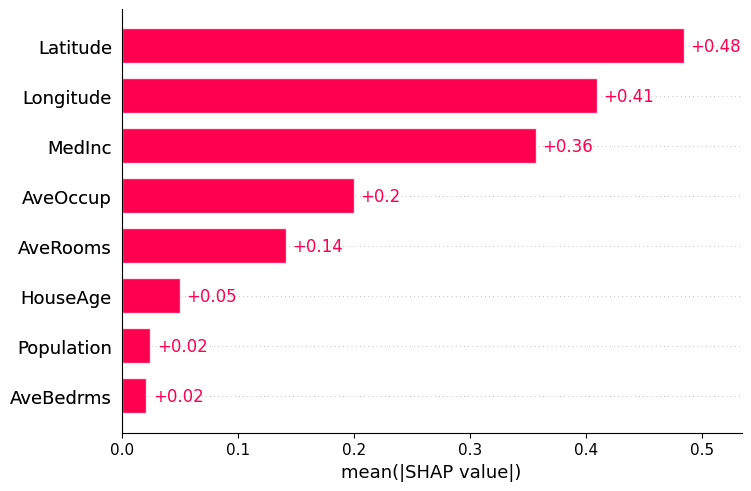

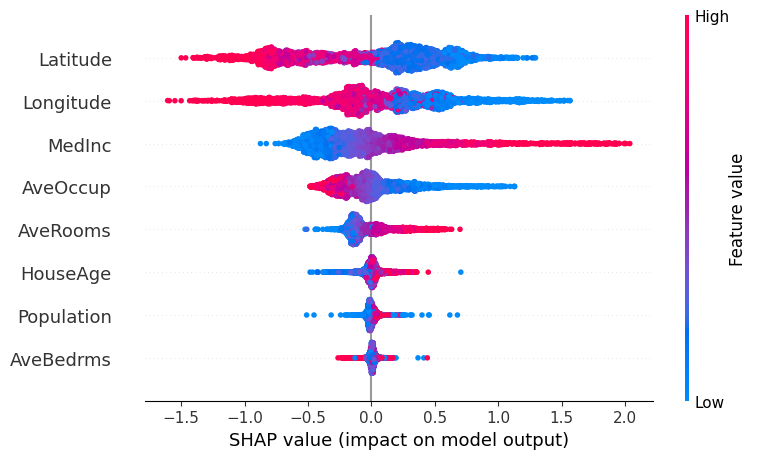

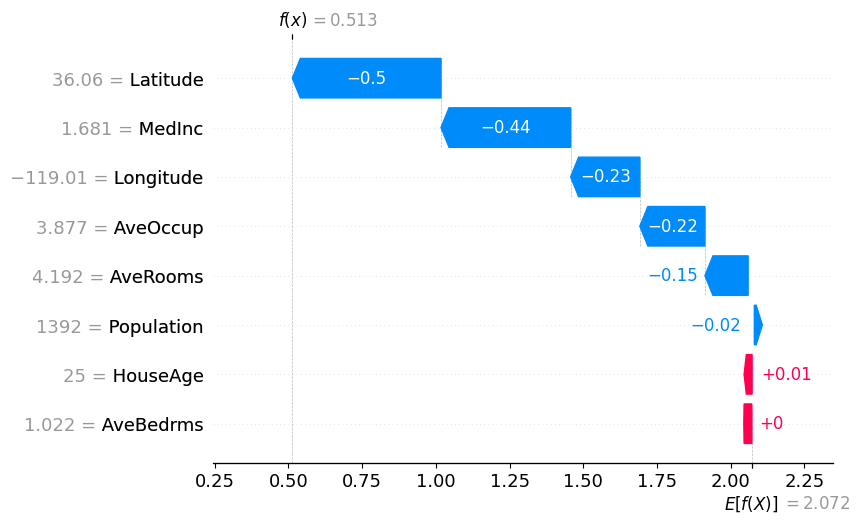

In [17]:
#shap analysis
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)

shap.summary_plot(shap_values, X_test)

shap.plots.waterfall(shap_values[0])


In [19]:
#Select Most Important Features from SHAP
# Compute mean absolute SHAP values
mean_shap = np.abs(shap_values.values).mean(axis=0)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': mean_shap
}).sort_values(by='importance', ascending=False)

print(feature_importance)


#select top 3
top_features = feature_importance['feature'].iloc[:3].tolist()
print("Top SHAP Features:", top_features)


      feature  importance
6    Latitude    0.484278
7   Longitude    0.408968
0      MedInc    0.356816
5    AveOccup    0.200055
2    AveRooms    0.141373
1    HouseAge    0.050048
4  Population    0.024883
3   AveBedrms    0.021393
Top SHAP Features: ['Latitude', 'Longitude', 'MedInc']


In [22]:
#use DiCE to generate counterfactuals
import dice_ml
from dice_ml import Dice

# Combine X and y
df = X.copy()
df['price'] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=X.columns.tolist(),
    outcome_name='price'
)

dice_model = dice_ml.Model(
    model=model,
    backend="sklearn",
    model_type="regressor"
)


dice_exp = Dice(dice_data, dice_model)


In [23]:
#increase predicted price
query_instance = X_test.iloc[0:1]

current_pred = model.predict(query_instance)[0]
desired = current_pred + 1.0  # increase by 1 unit

cf = dice_exp.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_range=[desired, desired+0.5],
    features_to_vary=top_features   # <-- SHAP selected features
)

cf.visualize_as_dataframe()


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

Query instance (original outcome : 1.0)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.060001,-119.010002,1.0



Diverse Counterfactual set (new outcome: [np.float32(1.5132282), np.float32(2.0132282)])


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,12.1969,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,1.940688
1,13.7662,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,1.940688
2,12.3259,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,1.940688


#Experimental what-if studies

In [25]:
#A) Actionable Counterfactual
cf_actionable = dice_exp.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_range=[desired, desired+0.5],
    features_to_vary=['MedInc', 'HouseAge']
)

cf_actionable.visualize_as_dataframe()


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

Query instance (original outcome : 1.0)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.060001,-119.010002,1.0



Diverse Counterfactual set (new outcome: [np.float32(1.5132282), np.float32(2.0132282)])


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.6977,43.5,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,1.849218
1,11.1977,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,1.940688
2,11.8476,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,1.940688


In [26]:
#B) Realistic Constraint Counterfactual
allowed_features = [f for f in X.columns if f not in ['Latitude', 'Longitude']]

cf_realistic = dice_exp.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_range=[desired, desired+0.5],
    features_to_vary=allowed_features
)

cf_realistic.visualize_as_dataframe()


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

Query instance (original outcome : 1.0)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.060001,-119.010002,1.0



Diverse Counterfactual set (new outcome: [np.float32(1.5132282), np.float32(2.0132282)])


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,9.5378,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,1.908277
1,1.6812,25.0,52.300000,1.022284,16971.9,3.877437,36.06,-119.01,1.655722
2,1.6812,25.0,29.500000,1.022284,1392.0,3.877437,36.06,-119.01,1.663378


#Required Observations

**One case where SHAP importance != counterfactual change**

query_instance = X_test.iloc[0:1]

For this instance:

SHAP Global Importance:
Latitude = 0.48
Longitude = 0.41
MedInc = 0.36

Counterfactual for that same instance:
MedInc changed from 1.68 → ~12–13
Latitude stayed 36.06
Longitude stayed –119.01

For the test instance X_test.iloc[0] with predicted value 1.0, SHAP identifies Latitude as the most globally important feature (0.48). However, the counterfactual explanation increases MedInc from 1.68 to above 12 while keeping Latitude constant at 36.06, demonstrating a mismatch between global importance(SHAP) and actionable recourse(counterfactual change).

This demonstrates that although location strongly influences predictions globally, changing income provides a more feasible and minimal adjustment to increase the predicted house price. Hence, SHAP identifies influential features, whereas DiCE identifies actionable recourse.

**One surprising feature behaviour**

The SHAP summary plot reveals that AveOccup exhibits a non-linear relationship. Moderate occupancy increases predicted price, while very high occupancy decreases it, suggesting the model captures overcrowding effects rather than simple linear trends.

**One Model Bias Observation**

The SHAP global importance values show that Latitude (0.48) and Longitude (0.41) are the two most influential features in the model, exceeding the contribution of income and other socioeconomic variables. This indicates that the model relies heavily on geographic location when predicting house prices.

As a result, properties in coastal regions tend to receive higher predicted values, while inland areas are systematically predicted lower prices, even when income levels are comparable. This suggests the presence of geographic bias, where spatial location disproportionately influences model predictions.